## IMPORTS

In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install --quiet git+https://github.com/eelregit/pmwd.git

In [ ]:
%pylab inline

import os
import moviepy.video.io.ImageSequenceClip
from IPython.display import HTML
from base64 import b64encode


import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

import jax.scipy as jsp
import pmwd

from matplotlib.colors import LogNorm


from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import optax

import time
import tqdm


Populating the interactive namespace from numpy and matplotlib
gpu


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clip']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# jaxPM is a JAX implementation of the N-body Particle-Mesh solver that solves the Poisson equation using FFTs.

You can find teh code here https://github.com/DifferentiableUniverseInitiative/JaxPM

The strength of this this JAX version is 2 fold as we saw in the intro:
1.   It is differentiable, jitted, can run on GPU and in parallel at scale
2.   It benefits from the numpy-like syntax, making it easy to read for any python user


Long story short what JaxPM does is evolving initial gaussian conditions through cosmic time.


So first, let's generate some initital conditions that follow the linear matter power spectrum.

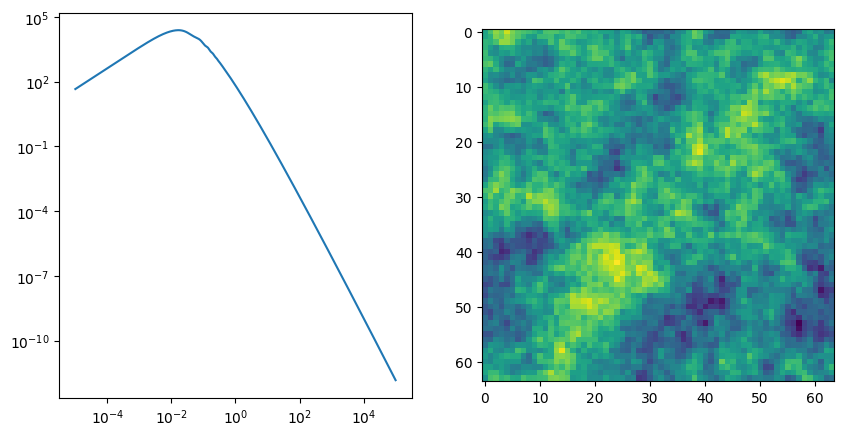

In [ ]:
%matplotlib inline

mesh_shape= [64, 64, 64] #number of mesh pixels/particules in x,y,z
box_size  = [20., 20., 20.] #comoving size of the box on Mpc/h
snapshots = jnp.linspace(0.1,1.,100) #scale factor (a) of snapshots to follow the redshift evolution
redshifts = 1/snapshots - 1. #redshifts of the snapshots

k = jnp.logspace(-5, 5, 512) #wave number vector to sample the matter power spectrum
cosmo = jc.Planck15() #set cosmology
pk = jc.power.linear_matter_power(cosmo, k) #get power spectrum

pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape) #make interpolation
linear = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(20)) #apply power spectrum to the 3d mesh/box to get a field realisation


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(k, pk) # plot 1D power spectrum
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.imshow(linear[32:].sum(axis=0)) #plot 2D projection of linear field

### Let's write the function that allows to go from initial conditions to final state of the N-body simulation and run it

In [ ]:
mesh_shape= [64, 64, 64]
box_size  = [20., 20., 20.]
snapshots = jnp.linspace(0.1,1.,100)
redshifts = 1/snapshots - 1

def run_simulation(mesh_shape, box_size, snapshots):#omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-5, 5, 512)
    cosmo = jc.Planck15() #Omega_c=omega_c, sigma8=sigma8)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(20))
    #initial_conditions = jax.random.normal(jax.random.PRNGKey(10), shape=mesh_shape)
    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15()
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)

    # Return the simulation volume at requested
    return res[0], initial_conditions

In [ ]:
start = time.time()
evolved_field, initial_conditions = run_simulation(mesh_shape, box_size, snapshots)
print('done in', time.time()-start)

done in 21.271108865737915


**Congratulations ! You have just run a $64^3$ particles N-body simulation**



The states of the simulation give us the position of the particles in mesh coordinates

In [ ]:
evolved_field[-1], evolved_field[-1].shape

(Array([[-1.933,  2.368, -0.376],
        [-4.353,  2.003,  1.146],
        ...,
        [61.665, 66.955, 63.778],
        [60.984, 66.774, 64.186]], dtype=float64),
 (262144, 3))

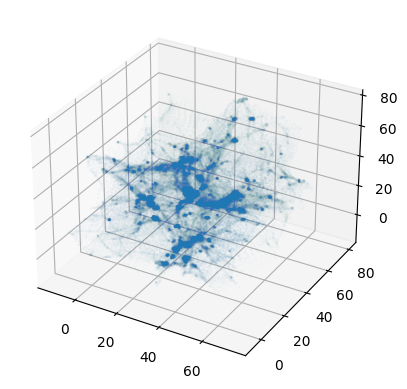

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = plt.subplot(projection='3d')
ax.scatter(evolved_field[-1, :, 0],
           evolved_field[-1, :, 1],
           evolved_field[-1, :, 2], s=0.0001)

Let's project this on the mesh grid using a cloud-in-cell (CIC) for each snapshot and make a movie

In [ ]:
#true_final = cic_paint(jnp.zeros(mesh_shape), evolved_field[-1])
#true_init = cic_paint(jnp.zeros(mesh_shape), evolved_field[0])

In [ ]:
%matplotlib Agg
painted_snapshots = []
for i in range(len(snapshots)):
    painted_snapshots.append(cic_paint(jnp.zeros(mesh_shape), evolved_field[i])[:32].sum(axis=0))
    fig, ax = plt.subplots()
    im = ax.imshow(painted_snapshots[i], norm=LogNorm(vmin=1e1, vmax=5e2), extent=[0,20,0,20])
    ax.text(2,18, r'$z = $'+"{:2.2f}".format(redshifts[i]), color='white')
    ax.set_xlabel(r'$x~[{\rm Mpc} / h]$')
    ax.set_ylabel(r'$y~[{\rm Mpc} / h]$')
    plt.tight_layout()
    plt.savefig('snapshot_'+str(i)+'.png', dpi=100, transparent=False)
    plt.close()

fps=8
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(['snapshot_'+str(i)+'.png'
                                                             for i in range(len(snapshots))], fps=fps)
clip.write_videofile('simu_video.mp4')


mp4 = open('simu_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Moviepy - Building video simu_video.mp4.
Moviepy - Writing video simu_video.mp4



Moviepy - Done !
Moviepy - video ready simu_video.mp4


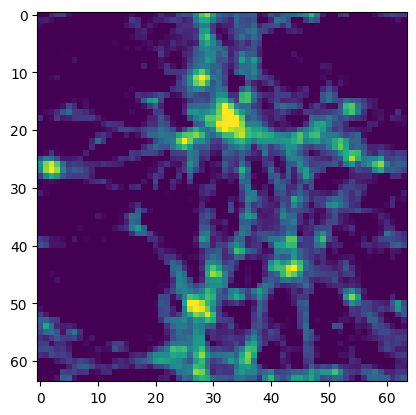

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(cic_paint(jnp.zeros(mesh_shape), evolved_field[-1])[:32].sum(axis=0), norm=LogNorm(vmin=1e1, vmax=5e2))

### Now that we know how to run a simulation, we can take adavantage of the fact that all our operations to run it are differentiable thanks to JAX to solve efficiently an optimizatiion problem (using the ADAM optimizer)

Our optimization problem is : **Let's infer the cosmic evolution of large-scale strutures (LSS) from an observation at low redshift**

\\

Let's use a smaller mesh shape for demonstration purposes (to accelerate things here). We generate a simulation amnd record the true inital and final state

In [ ]:
mesh_shape= [16, 50, 50]
box_size  = [25.,50.,50.]
snapshots = jnp.linspace(0.1,1.,3)
redshifts = 1/snapshots - 1

evolved_field, initial_conditions = run_simulation(mesh_shape, box_size, snapshots)

true_final = cic_paint(jnp.zeros(mesh_shape), evolved_field[-1])

#### Let's consider the true_final as our data. We will look to reconstruct the initial conditions of the simulation by evolving them and comparing the final state the data.

#### Let's define a loss function : normalized root mean square difference (NRMSE) between generated final state and data

In [ ]:
@jax.jit
def evolve(initial_conditions):
    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15()
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    final_state = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)

    #Likelihood term of data
    final = cic_paint(jnp.zeros(mesh_shape), final_state[0][-1])
    return final


@jax.jit
def loss_fn(initial_conditions):
    loss = (evolve(initial_conditions) - true_final).var() / true_final.var()
    return loss


In [ ]:
def fit(params: optax.Params,
        optimizer: optax.GradientTransformation) -> optax.Params:
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  losses = []
  params_save = []
  for i in tqdm.tqdm(range(nsteps)):
    params, opt_state, loss_value = step(params, opt_state)
    if i % 100 == 0:
      print(f'step {i}, loss: {loss_value}')
    losses.append(loss_value)
    params_save.append(params)

  return jnp.stack(losses), jnp.stack(params_save)


Let's run the optimization, starting with random (white noise) initial condition

In [ ]:
rng = jax.random.PRNGKey(100)
params= jax.random.normal(rng, mesh_shape)
#params = linear_field(mesh_shape, box_size, pk_fn, seed=rng)
#params = true_final + jax.random.normal(rng, true_final.shape)

nsteps = 100

optimizer = optax.adam(learning_rate=0.1)
losses, optim_params_array = fit(params, optimizer)

  0%|          | 1/1000 [00:12<3:25:19, 12.33s/it]

step 0, loss: 1.0053681896128586


 10%|█         | 101/1000 [00:53<07:03,  2.12it/s]

step 100, loss: 0.038226915029979915


 20%|██        | 201/1000 [01:41<06:21,  2.09it/s]

step 200, loss: 0.021656512251440996


 30%|███       | 301/1000 [02:28<05:20,  2.18it/s]

step 300, loss: 0.02170109156913705


 40%|████      | 401/1000 [03:14<04:34,  2.18it/s]

step 400, loss: 0.014590654713591535


 50%|█████     | 501/1000 [03:59<03:44,  2.22it/s]

step 500, loss: 0.013076546885372192


 60%|██████    | 601/1000 [04:45<03:04,  2.16it/s]

step 600, loss: 0.011634455142144822


 70%|███████   | 701/1000 [05:31<02:18,  2.16it/s]

step 700, loss: 0.011393464418004184


 80%|████████  | 801/1000 [06:18<01:32,  2.15it/s]

step 800, loss: 0.010994403427600163


 90%|█████████ | 901/1000 [07:04<00:46,  2.15it/s]

step 900, loss: 0.011771166407413072


100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


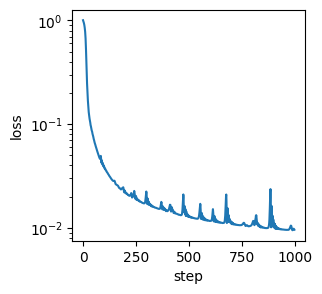

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(losses)

ax.set_ylabel('loss')
ax.set_xlabel('step')
ax.set_yscale('log')


In [ ]:
estimated_final = evolve(optim_params_array[losses.argmin()]) ##get optimal final estimate

Text(0, 0.5, '$y~[{\\rm Mpc}~h^{-1}]$')

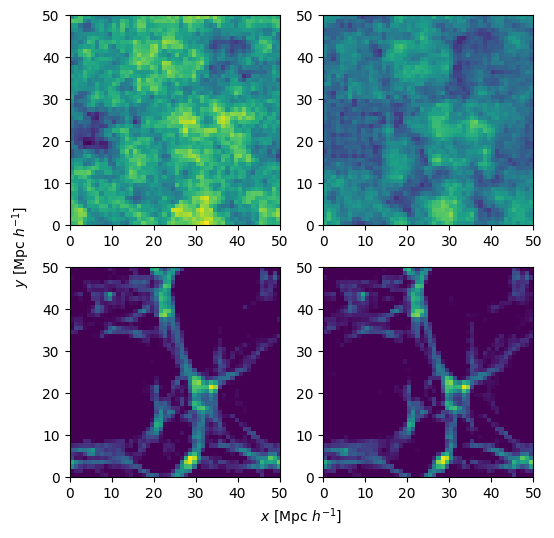

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[6,6])
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

ax1.imshow(initial_conditions.sum(axis=0), vmin=initial_conditions.sum(axis=0).min(),
           vmax=initial_conditions.sum(axis=0).max(), extent=[0, 50, 0, 50])

ax2.imshow(optim_params_array[losses.argmin()].sum(axis=0),
           vmin=initial_conditions.sum(axis=0).min(),
           vmax=initial_conditions.sum(axis=0).max(), extent=[0, 50, 0, 50])


ax3.imshow(true_final.sum(axis=0), norm=LogNorm(vmin=1e1, vmax=5e2), extent=[0,50,0,50])
ax4.imshow(estimated_final.sum(axis=0), norm=LogNorm(vmin=1e1, vmax=5e2), extent=[0,50,0,50])

ax.set_xlabel(r'$x~[{\rm Mpc}~h^{-1}]$', fontsize=10)
ax.set_ylabel(r'$y~[{\rm Mpc}~h^{-1}]$', fontsize=10)

 Let's make a movie to see how our reconstruction was optimized

In [ ]:
%matplotlib Agg
reconstructed_frames_final = []
reconstructed_frames_initial = []

'''
indices2 = []
for i in np.arange(100, 1000, 100):
  indices2.append((i+losses[i:i+100].argmin()))
indices2 = np.array(indices2)

indices = np.append(np.append(np.arange(0, 50), 100), indices2)
'''
indices = np.arange(0, 100)

for i, idx in enumerate(indices):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])
    ax = fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    ax1.imshow(initial_conditions.sum(axis=0), extent=[0,50,0,50])
    ax1.set_title(r'true initial field')
    ax3.imshow(true_final.sum(axis=0), norm=LogNorm(vmin=1e1, vmax=5e2), extent=[0,50,0,50])
    ax3.set_title(r'true final field')

    reconstructed_frames_initial.append(optim_params_array[idx].sum(axis=0))
    ax2.imshow(reconstructed_frames_initial[i], extent=[0,50,0,50])
    ax2.text(2,48, r'$i = $'+str(idx), color='white')
    ax1.set_title(r'reconstructed initial field')

    reconstructed_frames_final.append(evolve(optim_params_array[idx]).sum(axis=0))
    ax4.imshow(reconstructed_frames_final[i], norm=LogNorm(vmin=1e1, vmax=5e2), extent=[0,50,0,50])
    ax4.text(2,48, r'$i = $'+str(idx), color='white')
    ax1.set_title(r'reconstructed final field')

    ax.set_xlabel(r'$x~[{\rm Mpc}~h^{-1}]$', fontsize=14)
    ax.set_ylabel(r'$y~[{\rm Mpc}~h^{-1}]$', fontsize=14)

    plt.tight_layout()

    plt.savefig('recon_'+str(idx)+'.png', dpi=100, transparent=False)
    plt.close()



fps=3
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(['recon_'+str(idx)+'.png'
                                                             for idx in indices], fps=fps)
clip.write_videofile('recon_video.mp4')

mp4 = open('recon_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Moviepy - Building video recon_video.mp4.
Moviepy - Writing video recon_video.mp4



Moviepy - Done !
Moviepy - video ready recon_video.mp4


In [ ]:
### let's try to parralelize with xmap
### to run higher resolution simulations.  TO DO...